In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as preproc
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree,metrics
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.model_selection import KFold

We have added more time features to see if we improve the accuracy

In [120]:
data = pd.read_excel('Case1_data.xlsx')
data=data.drop(columns=['FlightNumber'])
is_NaN = data.isnull();row_has_NaN = is_NaN.any(axis=1);rows_with_NaN = data[row_has_NaN]
data = data.drop(list(rows_with_NaN.index))
data=data.reset_index()
data.AircraftType=data.AircraftType.astype('str')

def apply_OneHotEncoder(data_col):
    # creating instance of one-hot-encoder
    enc = OneHotEncoder(handle_unknown='ignore')
    # passing bridge-types-cat column (label encoded values of bridge_types)
    enc_df = pd.DataFrame(enc.fit_transform(data_col).toarray())
    d={}
    for i in range (0,len(np.unique(data_col))):
        d[i]=enc.categories_[0][i]
    enc_df=enc_df.rename(columns=d)
    return enc_df

DateTime_dic = {'Month':[],'Year':[],'Hour':[],'Minute':[],'Day_Of_Year':[],'Day_Of_Week':[],
               'Is_month_end':[],'Is_month_start':[],'Quarter_end':[],'Quarter_start':[],'Year_end':[],
               'Year_Start':[],'Quarter':[]}

for a in data['ScheduleTime']:
    DateTime_dic['Month'].append(a.month);DateTime_dic['Year'].append(a.year)
    DateTime_dic['Hour'].append(a.hour);DateTime_dic['Minute'].append(a.minute);
    DateTime_dic['Day_Of_Year'].append(a.dayofyear);DateTime_dic['Day_Of_Week'].append(a.dayofweek);
    DateTime_dic['Is_month_end'].append(int(a.is_month_end));
    DateTime_dic['Is_month_start'].append(int(a.is_month_start));
    DateTime_dic['Quarter_end'].append(int(a.is_quarter_end));
    DateTime_dic['Quarter_start'].append(int(a.is_quarter_start));
    DateTime_dic['Year_end'].append(int(a.is_year_end));DateTime_dic['Year_Start'].append(int(a.is_year_start));
    DateTime_dic['Quarter'].append(a.quarter)
    
pd_time=pd.DataFrame.from_dict(DateTime_dic)
y=np.array(data.LoadFactor)
data=data.drop(columns='LoadFactor')

df = pd.concat([apply_OneHotEncoder(data[['Airline']]),apply_OneHotEncoder(data[['Destination']]),
                apply_OneHotEncoder(data[['AircraftType']]),apply_OneHotEncoder(data[['FlightType']]),
                apply_OneHotEncoder(data[['Sector']]),pd_time,pd.DataFrame(data.SeatCapacity)],axis=1)
                                                                          
X=np.array(df)
# NORMALIZATION
X_pre = X - np.mean(X,axis=0)
normalizer = preproc.Normalizer().fit(X_pre.T)  
X_pre = normalizer.transform(X_pre.T).T
min_max_scaler = preproc.MinMaxScaler()
y_pre = min_max_scaler.fit_transform(y.reshape(-1,1)).reshape(-1,)

In [121]:
df

,AY,BJ,BT,BZ,CL,CN,DO,DT,DU,EM,...,Day_Of_Year,Day_Of_Week,Is_month_end,Is_month_start,Quarter_end,Quarter_start,Year_end,Year_Start,Quarter,SeatCapacity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,0,1,0,1,0,1,1,142
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,0,1,0,1,0,1,1,74
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,0,1,0,1,0,1,1,142
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,4,0,1,0,1,0,1,1,72
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,4,0,1,0,1,0,1,1,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39,1,0,0,0,0,0,0,1,180
36764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39,1,0,0,0,0,0,0,1,156
36765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39,1,0,0,0,0,0,0,1,156
36766,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,39,1,0,0,0,0,0,0,1,189


In [122]:
# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# define feature selection
fs = SelectKBest(score_func=f_regression, k=100)
# apply feature selection
X_selected = fs.fit_transform(X_pre, y_pre)
print(X_selected.shape)

(36768, 100)


In [155]:
def find_opt_num_features(X_pre,y_pre,K=5,model= RandomForestRegressor(n_estimators=100),second_iter=False):
    # FIRST ITERATION: aiming to find a limited range of values in which the number of features is optimal
    Total_Error=[]
    kf = KFold(n_splits=K)
    # we assume that at least 200 features (out of 400's) will be needed in order to obtain the best accuracy
    num_features=np.linspace(200,np.shape(X)[1],10).astype('int')

    for el in num_features:
        # define feature selection
        fs = SelectKBest(score_func=f_regression, k=el)
        # apply feature selection
        X_selected = fs.fit_transform(X_pre, y_pre)
        tic()
        Error=[]
        for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
            X_train = X_selected[train_index]
            y_train = y_pre[train_index]
            X_test = X_selected[test_index]
            y_test = y_pre[test_index]
            # train model
            model.fit(X_train,y_train)
            # predict model
            y_pred=model.predict(X_test)
            # compute error
            Error.append(metrics.mean_absolute_error(y_test,y_pred))
        print(el)
        print('Elapsed time:',toc())
        print(np.mean(Error))
        Total_Error.append(Error)
        
    Mean_error=list(np.array(Total_Error).mean(axis=1))
    Opt_num_feat=num_features[Mean_error.index(min(Mean_error))]
    
    if second_iter==True:  
        # SECOND ITERATION: aiming to find a more precise number of features between the range found before
        Total_Error_2=[]
        kf = KFold(n_splits=K)
        num_features2=np.linspace(Opt_num_feat-15,Opt_num_feat+15,10).astype('int')

        for el in num_features:
            # define feature selection
            fs = SelectKBest(score_func=f_regression, k=el)
            # apply feature selection
            X_selected = fs.fit_transform(X_pre, y_pre)
            tic()
            Error=[]
            for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
                X_train = X_selected[train_index]
                y_train = y_pre[train_index]
                X_test = X_selected[test_index]
                y_test = y_pre[test_index]
                # train model
                model.fit(X_train,y_train)
                # predict model
                y_pred=model.predict(X_test)
                # compute error
                Error.append(metrics.mean_absolute_error(y_test,y_pred))
            print(el)
            print('Elapsed time:',toc())
            print(np.mean(Error))
            Total_Error_2.append(Error)

        Mean_error2=list(np.array(Total_Error_2).mean(axis=1))
        Opt_num_feat_final=num_features[Mean_error2.index(min(Mean_error2))]

        return num_features, Mean_error, num_features2, Mean_error2, Opt_num_feat_final
    else:
        return num_features, Mean_error, Opt_num_feat

In [156]:
find_opt_num_features(X_pre,y_pre)

200
Elapsed time: 100.44608929100286
0.12580891707923397
223
Elapsed time: 108.51824616700105
0.1264568155952662
246
Elapsed time: 117.19139108300078
0.12499652139959476
270
Elapsed time: 124.67182675000004
0.1260894018953594
293
Elapsed time: 133.44573662499897
0.12541340032449805
316
Elapsed time: 139.86154425000132
0.125675142442972
340
Elapsed time: 149.60384141599934
0.12538518044986494
363
Elapsed time: 162.9992294170006
0.12566180899743862
386
Elapsed time: 169.46702983399882
0.12496828641871707
410
Elapsed time: 179.4102085839986
0.125183147418516


(array([200, 223, 246, 270, 293, 316, 340, 363, 386, 410]),
 [0.12580891707923397,
  0.1264568155952662,
  0.12499652139959476,
  0.1260894018953594,
  0.12541340032449805,
  0.125675142442972,
  0.12538518044986494,
  0.12566180899743862,
  0.12496828641871707,
  0.125183147418516],
 386)

In [114]:
Error=[]
for el in np.linspace(100,np.shape(X)[1],10).astype('int'):
    # define feature selection
    fs = SelectKBest(score_func=f_regression, k=el)
    # apply feature selection
    X_selected = fs.fit_transform(X_pre, y_pre)
    
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_pre, test_size=0.30, random_state=42)
    # train model
    model= RandomForestRegressor(n_estimators=100)
    model.fit(X_train,y_train)
    # predict model
    y_pred=model.predict(X_test)
    # compute error
    Error.append(metrics.mean_absolute_error(y_test,y_pred))

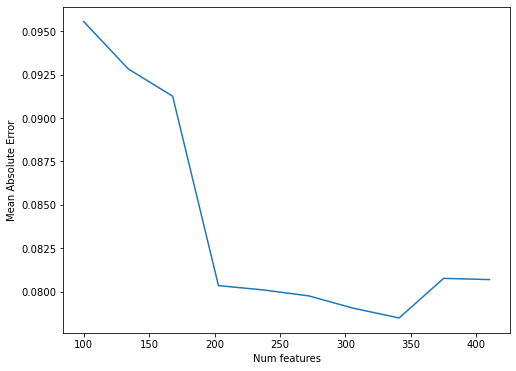

In [115]:
plt.figure(figsize=(8,6))
plt.plot(np.linspace(100,np.shape(X)[1],10).astype('int'),Error)
plt.xlabel('Num features');plt.ylabel('Mean Absolute Error')
plt.show()

From the graph above we can observe how the range of number of features to work within is from 200 to 410.

Let's do 5 folds cross validation for every num features param, so as to obtain more reliable results.

In [123]:
from ttictoc import tic,toc

Total_Error=[]
K=5
kf = KFold(n_splits=K)
num_features=np.linspace(200,np.shape(X)[1],10).astype('int')

for el in num_features:
    # define feature selection
    fs = SelectKBest(score_func=f_regression, k=el)
    # apply feature selection
    X_selected = fs.fit_transform(X_pre, y_pre)

    Error=[]
    for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
        tic()
        X_train = X_selected[train_index]
        y_train = y_pre[train_index]
        X_test = X_selected[test_index]
        y_test = y_pre[test_index]
        # train model
        model= RandomForestRegressor(n_estimators=100)
        model.fit(X_train,y_train)
        # predict model
        y_pred=model.predict(X_test)
        # compute error
        Error.append(metrics.mean_absolute_error(y_test,y_pred))
        print('Elapsed time:',toc())
    print(el)
    print(np.mean(Error))
    Total_Error.append(Error)

Elapsed time: 19.755724082999222
Elapsed time: 20.786882833999698
Elapsed time: 20.687411707998763
Elapsed time: 20.825248582999848
Elapsed time: 19.235260625000592
200
0.12607069763599316
Elapsed time: 20.682118458000332
Elapsed time: 22.255140957999174
Elapsed time: 22.100754834000327
Elapsed time: 23.07353937500011
Elapsed time: 21.57498141600081
223
0.12637594195751423
Elapsed time: 22.935943500000576
Elapsed time: 23.170886249999967
Elapsed time: 24.331376542000726
Elapsed time: 25.39416329100095
Elapsed time: 22.665399792000244
246
0.12572840247613135
Elapsed time: 24.204223415999877
Elapsed time: 25.005477665999933
Elapsed time: 25.952210499999637
Elapsed time: 26.618843916001424
Elapsed time: 24.853753708999648
270
0.12504961756814695
Elapsed time: 26.80386958300005
Elapsed time: 27.01048137500038
Elapsed time: 28.127473000000464
Elapsed time: 29.470074875000137
Elapsed time: 25.878812999999354
293
0.12521302319224414
Elapsed time: 26.80068691700035
Elapsed time: 27.11165812499

In [132]:
np.array(Total_Error).shape

(10, 5)

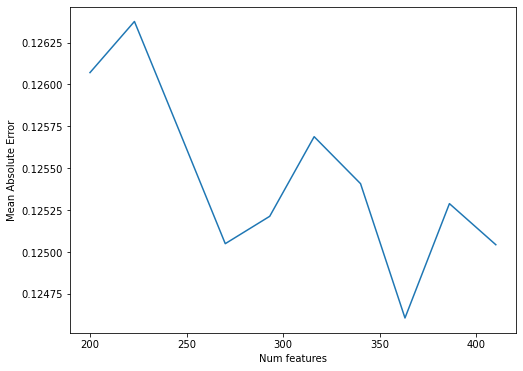

In [136]:
plt.figure(figsize=(8,6))
plt.plot(num_features,np.array(Total_Error).mean(axis=1))
plt.xlabel('Num features');plt.ylabel('Mean Absolute Error');plt.show()

We are gonna do the same around 350-375:

In [137]:
Total_Error_2=[]
K=5
kf = KFold(n_splits=K)
num_features=np.linspace(350,375,10).astype('int')

for el in num_features:
    # define feature selection
    fs = SelectKBest(score_func=f_regression, k=el)
    # apply feature selection
    X_selected = fs.fit_transform(X_pre, y_pre)

    Error=[]
    for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
        tic()
        X_train = X_selected[train_index]
        y_train = y_pre[train_index]
        X_test = X_selected[test_index]
        y_test = y_pre[test_index]
        # train model
        model= RandomForestRegressor(n_estimators=100)
        model.fit(X_train,y_train)
        # predict model
        y_pred=model.predict(X_test)
        # compute error
        Error.append(metrics.mean_absolute_error(y_test,y_pred))
        print('Elapsed time:',toc())
    print(el)
    print(np.mean(Error))
    Total_Error_2.append(Error)

Elapsed time: 28.97560579200035
Elapsed time: 30.49246058300014
Elapsed time: 32.699576582999725
Elapsed time: 32.34744120799951
Elapsed time: 30.340177165999194
350
0.12543907233353882
Elapsed time: 29.675278291000723
Elapsed time: 29.949215459000698
Elapsed time: 32.074797999999646
Elapsed time: 33.530386165999516
Elapsed time: 30.048071957999127
352
0.12500279083692134
Elapsed time: 30.870854624999993
Elapsed time: 32.60667779100004
Elapsed time: 34.35057854099978
Elapsed time: 34.098878999999215
Elapsed time: 31.894838625001285
355
0.12564095778363682
Elapsed time: 31.42463287499959
Elapsed time: 31.31489474999944
Elapsed time: 32.265015959001175
Elapsed time: 34.3447523750001
Elapsed time: 31.726577833000192
358
0.12474800993910606
Elapsed time: 31.591716083999927
Elapsed time: 31.71274245799941
Elapsed time: 33.449462917000346
Elapsed time: 35.26444133399855
Elapsed time: 32.508508458000506
361
0.12543333669143658
Elapsed time: 31.729270625000936
Elapsed time: 32.09514379199936
E

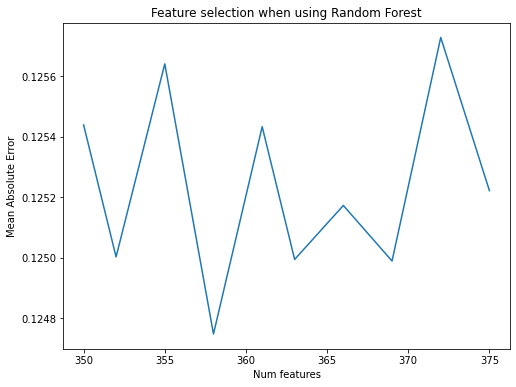

The optimal number of features when using a random forest model is 358


In [146]:
Mean_error2=list(np.array(Total_Error_2).mean(axis=1))
plt.figure(figsize=(8,6))
plt.plot(num_features,Mean_error2)
plt.title('Feature selection when using Random Forest')
plt.xlabel('Num features');plt.ylabel('Mean Absolute Error');plt.show()
Opt_num_feat=num_features[Mean_error2.index(min(Mean_error2))]
print('The optimal number of features when using a random forest model is',Opt_num_feat)

---

In [98]:
K=10
kf = KFold(n_splits=K)
num_features=np.linspace(100,np.shape(X)[1],10).astype('int')
Error = np.zeros(len(num_features))

Opt_features=np.zeros(K)
Total_Error=np.zeros(K)
for i, (train_index, test_index) in enumerate(kf.split(X_pre)):
    # define feature selection
    fs = SelectKBest(score_func=f_regression, k=num_features[i])
    # apply feature selection
    X_opt = fs.fit_transform(X_pre, y_pre)
    
    X_train = X_opt[train_index]
    y_train = y_pre[train_index]
    X_test = X_opt[test_index]
    y_test = y_pre[test_index]
    
    # train the model with the selected features
    model= RandomForestRegressor(n_estimators=100)
    model.fit(X_train,y_train)
    # predict y using the trained model
    y_pred=model.predict(X_test)
    # compute error
    Total_Error[i] = metrics.mean_absolute_error(y_test,y_pred)
    Opt_features[i]= num_features[i]
    print(num_features[i])
    print(metrics.mean_absolute_error(y_test,y_pred))

100
0.11674080514303727
134
0.16066208024313142
168
0.11956249318681113
203
0.10717138699449291
237
0.09790602645715134
272
0.09856030034180402
306
0.10467961866138357
341
0.14700888026721834
375
0.11587058821091976
410
0.10978048211390509


---

### Coses randoms q no mhan anat

In [97]:
K=10
kf = KFold(n_splits=K)
num_features=np.linspace(100,np.shape(X)[1],K).astype('int')
Error = np.zeros(len(num_features))

Opt_features=np.zeros(K)
Total_Error=np.zeros(K)
for i, (train_index, test_index) in enumerate(kf.split(X_pre)):
    # TRAINING FOLDS
    X_train = X_pre[train_index]
    y_train = y_pre[train_index]
    
    Error=np.zeros(len(num_features))
    
    # we find the best number of feature for the specific CV fold
    for j, (train_inn_index, test_inn_index) in enumerate(kf.split(X_train)):
            # define feature selection
            fs = SelectKBest(score_func=f_regression, k=num_features[j])
            # apply feature selection
            X_selected = fs.fit_transform(X_train, y_train) # we use the outer train fold to find the best num feature
            
            X_inn_train = X_selected[train_inn_index]
            y_inn_train = y_train[train_inn_index]
            X_inn_test = X_selected[test_inn_index]
            y_inn_test = y_test[test_inn_index]
            
            # train the model with the selected features
            model= RandomForestRegressor(n_estimators=100)
            model.fit(X_inn_train,y_inn_train)
            # predict y using the trained model
            y_pred=model.predict(X_inn_test)
            # compute error
            Error[j] = metrics.mean_absolute_error(y_inn_test,y_pred)
            print(metrics.mean_absolute_error(y_inn_test,y_pred))
    
    # We pick the number of features that gave the minimum error for this specific fold
    idx_min=list(Error).index(min(Error))
    
    # define feature selection
    fs = SelectKBest(score_func=f_regression, k=num_features[idx_min])
    # apply feature selection
    X_opt = fs.fit_transform(X_train, y_train)

    # train the model with the selected features
    model= RandomForestRegressor(n_estimators=100)
    model.fit(X_opt[train_index],y_train)
    
    # TESTING FOLDS
    X_test = X_opt[test_index]
    y_test = y_pre[test_index]
    
    # predict y using the trained model
    y_pred=model.predict(X_test)
    # compute error
    Total_Error[i] = metrics.mean_absolute_error(y_test,y_pred)
    Opt_features[i]= num_features[idx_min]
    print(num_features[idx_min])
    print(metrics.mean_absolute_error(y_test,y_pred))


/Users/lluiscolomercoll/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) -


0.18999923546744843


/Users/lluiscolomercoll/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) -


0.16078098905032265


/Users/lluiscolomercoll/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) -


IndexError: index 7353 is out of bounds for axis 0 with size 7353

In [11]:
metrics.mean_absolute_error(y_test,y_pred)

0.09566732970906489

Before x selected 0.08051163334460525

0.08047546486930399

Before doing one encoding to all time features: 0.08207498064062252 (mean_absolute_error)

Before doing one encoding to all time features: 0.09574269766891995 (mean_absolute_error)